# Importing Data

In [ ]:
# Libs

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from scipy import signal
from scipy.interpolate import interp1d

In [ ]:
FILE_PATH = '/content/drive/MyDrive/01 - Iniciação Científica/02 - Datasets/csv_files/EN2_STAR_MON_0110864907_20081116T190224_20090311T103233.csv'

In [ ]:
df = pd.read_csv(FILE_PATH)
df.head()

,DATEBARTT,WHITEFLUXSYS
0,54787.299674,27374.818
1,54787.305601,27474.370
2,54787.311527,27435.758
3,54787.317453,27473.264
4,54787.323380,27447.828


In [ ]:
x = df.DATEBARTT.to_numpy()
y = df.WHITEFLUXSYS.to_numpy()

### Before results

In [ ]:
fig = px.line(df, x=x, y=y, title='Light Curve before filtering')

fig.update_layout(title='Light Curve before filtering',
                   xaxis_title='Databartt',
                   yaxis_title='Whiteflux')

fig.show()

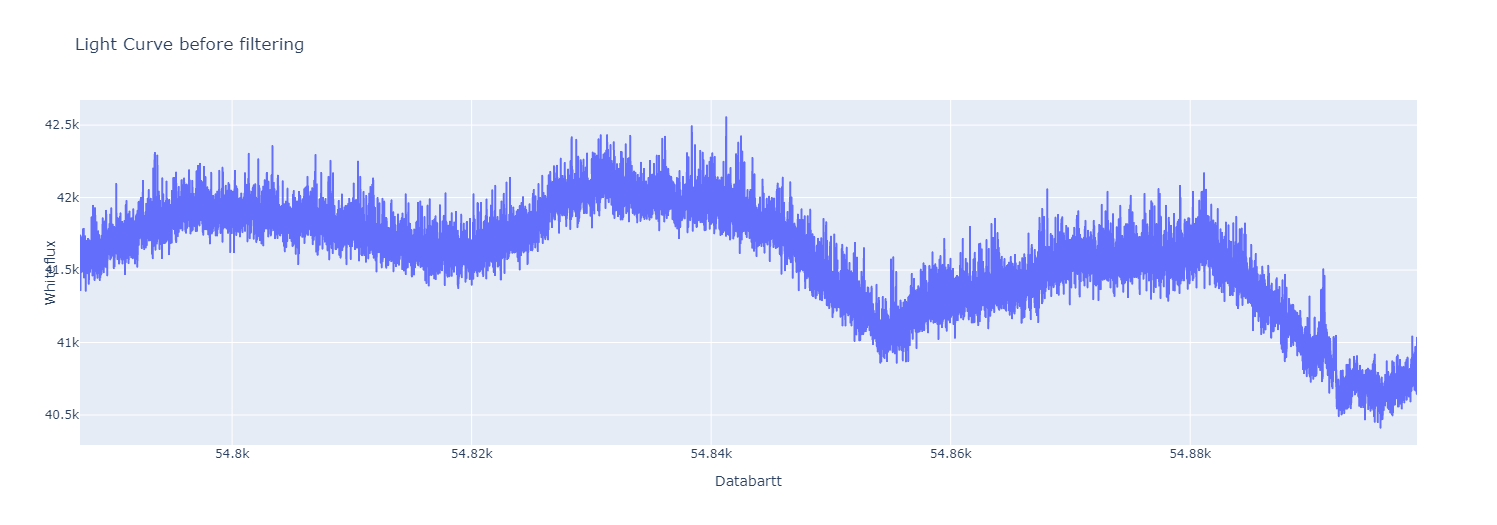

# Data normalization

Before applying Butterworth filter, we have to ...
- Create artificial borders
- Apply Zero Padding algorithm

## 1. Artificial borders

Our first step is to add artificial borders to the array. After some studies and test it is notable that, for some reason, when the Butterworth filter is used, it can create some distorcion on the first and last values of the array.

Intend to avoid this unexpected values, we add some points on the begining and at the end of the array, so the distorcion will occur on this artificial borders that we create. Then, we just have to cut them off to return to the original array.

In order to not modify the array too much, the function *artificial_borders* will add 15 points on the begining that have the same value as the first element, y[0] and, just like at the begining, at the end, we will add 15 points that have the same value as the lastest element, y[-1].

In [ ]:
def artifical_borders(array, num):
  aux_pre = np.zeros(num)
  aux_pos = np.zeros(num)
  i = 0
  for i in range(num):
    aux_pre[i] = array[0]
    aux_pos[i] = array[-1]
  
  return np.concatenate((aux_pre, array, aux_pos)).ravel()

In [ ]:
# Defining the numbers of points to be added

param = 70

In [ ]:
x_artifical_borders = artifical_borders(x, param)
y_artifical_borders = artifical_borders(y, param)

print("The original length was:", len(x), ", and now we have:", len(x_artifical_borders), "\nThe difference is:", (len(x_artifical_borders) - len(x) ))

The original length was: 19346 , and now we have: 19486 
The difference is: 140


## 2. Zero Padding

One good practice before filtering data with Butterworth is to apply a procedure called Zero Padding. It consists of extending a signal with zeros, that is, it return a lenght $N$ signal to a lenght $M > N$ signal, but $N$ can not be divisible by $M$.


Zero Padding, $f_{zp}$, has the following definition: 

$$ f_{zp}(x) \triangleq \begin{cases}
   f(x), &\text{if } |m| < N/2 \\
   0, &\text{otherwise }
\end{cases} $$

where: 

$m = 0, \pm1, \pm2, \pm3, ...\pm M_{h}$, with $M_h \triangleq (M-1)/2 $ for $M$ odd, and $M/2-1$ for $M$ even. 

<br />Padding remove the implicit periodicity of the funcion that can appeared on the filtered data.
In other terms, the padding prevents the convolution of two functions from generating unexpected (periodic) results.

In [ ]:
def padding(array):
  return np.append(array, np.zeros(len(array)))

In [ ]:
x_padding = padding(x_artifical_borders)
y_padding = padding(y_artifical_borders)

print("The previous length was:", len(x_artifical_borders), ", and now we have:", len(x_padding), "\nThe difference is:", (len(x_padding) - len(x_artifical_borders) ))

The previous length was: 19486 , and now we have: 38972 
The difference is: 19486


In [ ]:
# Plotting the graphic

fig = px.scatter(x=x_padding, y=y_padding, title="Light Curve 'Padded'")

fig.update_layout(title="Light Curve 'Padded'",
                   xaxis_title='Databartt with Padding',
                   yaxis_title='Whiteflux with Padding')
fig.show()

# We can see that it was created a lot of point equals to (0, 0)

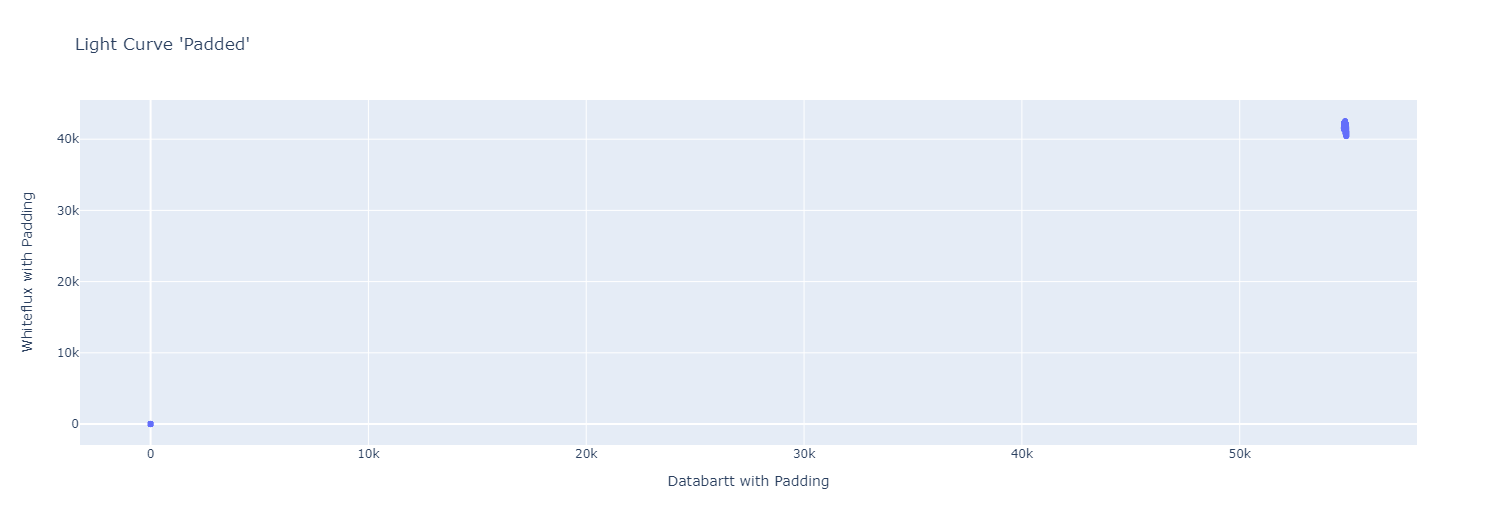

Now, our date is ready to be filtered.

The next step is to apply the Butterworth filter.

# Butterworth Filter

Finally, we must multiply the results of Fourier transform by the filter's function, in this case, by the Butterworth Transfer function $H_{n} (j\space\omega)$.

$$ 
G_{n}(\omega)  = |H_{n}(j\space\omega)| = \frac{1}{ \sqrt{ 1 + \big(\frac{\omega}{\omega_c}\big)^{2n} } } 
$$

where:

- G is the gain of an n-order Butterworth low-pass filter
- H is transfer funcion
- j is imaginary number
- n is the order of the filter
- ω  is the angular frequency [rad/s],
- $\omega_c$ is the cutoff frequency [rad/s].

In [ ]:
# Filter parameters
filter_order = 2
cutoff_freq_hz = 25
sampling_freq_hz = 1500

In [ ]:
def butterworth_filter(filter_order, cutoff_freq_hz, sampling_freq_hz, original_signal):
  # Butterworth filter coefficients
  filter_coefficients_butterworth = signal.iirfilter(filter_order, cutoff_freq_hz, btype='lowpass', analog=False, ftype='butter', fs=sampling_freq_hz, output='ba')

  # Filter frequency response
  frequency_response_samples = len(original_signal)
  filter_response_butterworth = signal.freqz(filter_coefficients_butterworth[0], filter_coefficients_butterworth[1], frequency_response_samples, fs=sampling_freq_hz)

  # Defining step_time and step_signal as our data

  step_signal = original_signal

  # Filter response
  return signal.lfilter(filter_coefficients_butterworth[0], filter_coefficients_butterworth[1], step_signal)

In [ ]:
light_curve_filtered = butterworth_filter(filter_order=2, cutoff_freq_hz=25, sampling_freq_hz=1500, original_signal=y_padding)

# Applying butterworth filter to original data intend to not plot zero padding results
light_curve_filtered_plot = butterworth_filter(filter_order=2, cutoff_freq_hz=25, sampling_freq_hz=1500, original_signal=y)

In [ ]:
# Plotting results
fig = go.Figure()

fig.add_trace(go.Scatter(x=x[param:], y=light_curve_filtered_plot[param:],
                           mode='lines',
                           name='Light Curve Filtered'))

fig.update_layout(title='Filtered results',
                   xaxis_title='Datebartt',
                   yaxis_title='Whiteflux')

fig.show()

In [ ]:
x_butter = x_padding
y_butter = light_curve_filtered

# Undoing normalization procedures

Now, we have to undo what we've done on Data normalization. This is mandatory because, considering all these procedures as an equation, we must keep it balenced and, for that, every manipulation we did on one side, we have to do on the other.


## Removing Zero Padding

In [ ]:
x_no_padding = x_butter[:int(len(x_butter)/2)]
y_no_padding = y_butter[:int(len(y_butter)/2)]

print("The before length was:", len(x_butter), ", and now we have:", len(x_no_padding))

The before length was: 38972 , and now we have: 19486


## Cuting artificial borders

In [ ]:
param = param # equals 70

In [ ]:
x_aux = np.delete(x_no_padding, np.s_[:param])
x_filtered = np.delete(x_aux, np.s_[-param:])

y_aux = np.delete(y_no_padding, np.s_[:param])
y_filtered = np.delete(y_aux, np.s_[-param:])

# Filtering results

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=y,
                           mode='lines',
                           name='Original Light Curve'))

fig.add_trace(go.Scatter(x=x_filtered, y=y_filtered,
                           mode='lines',
                           name='Light Curve Filtered'))

fig.update_layout(title='Light Curve before and after the Butterworth filter',
                   xaxis_title='Databartt',
                   yaxis_title='Whiteflux')

fig.show()

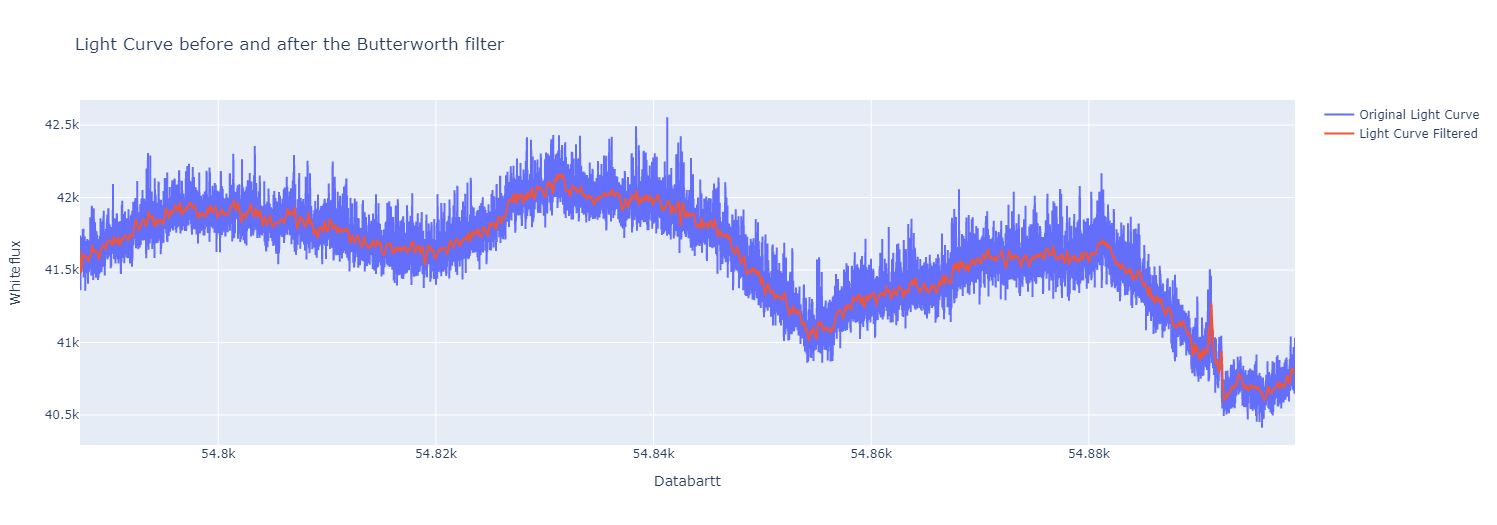